#  Generate instrumental transmission curves for Auxtel, ie total throughput 

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS
- creatiion date : 2024-01-02
- update : 2024-04-06


Generate instrumental transmission curves for Auxtel photometry


**Deprecated**

In [1]:
# Import some generally useful packages

import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from scipy.interpolate import interp1d

In [2]:
# Import the primary photometry classes from rubin_sim.photUtils
from rubinsimphot.phot_utils import Bandpass, Sed
from rubinsimphot.data.data_sets import  get_data_dir

## Read the throughput curves ##

The throughput curves are currently downloaded as part of the `rs_download_data` script, and stored in `$RUBIN_SIM_DATA_DIR`. The default value for `$RUBIN_SIM_DATA_DIR` is `$HOME/rubin_sim_data`. 

In [3]:
fdir = get_data_dir()
print(fdir)

/Users/dagoret/MacOSX/GitHub/LSST/AtmosphericSimulation/rubinsimphot/src/rubin_sim_data


In [4]:
# Find the throughputs directory 
#fdir = os.getenv('RUBIN_SIM_DATA_DIR')
fdir = get_data_dir()
if fdir is None:  #environment variable not set
    fdir = os.path.join(os.getenv('HOME'), 'rubin_sim_data')


fdir = os.path.join(fdir, 'throughputs', 'auxtel')
ldir = "./"

In [5]:
telescope_throughput = "multispectra_holo4_003_HD142331_20230802_AuxTel_doGainsPTC_v3.0.3_throughput.txt"

In [6]:
tel_auxtel =  Bandpass()
tel_auxtel.read_throughput(os.path.join(fdir, telescope_throughput ))

/Users/dagoret/MacOSX/GitHub/LSST/AtmosphericSimulation/rubinsimphot/src/rubinsimphot/phot_utils/bandpass.py:68: UserWarning: Wavelength sampling of 1.0 nm is > 0.2 nm, this may not work well with a Sed object. Consider resampling with resample_bandpass method.
  warnings.warn(


In [8]:
# Read the throughput curves
#filterlist = ['u', 'g', 'r', 'i','z']
filterlist = ['up', 'gp', 'rp', 'ip','zp','yp']

sdss_p = {}
for f in filterlist:
    sdss_p[f] = Bandpass()
    sdss_p[f].read_throughput(os.path.join(fdir, f'auxtel_sdss_{f}.dat'))

/Users/dagoret/MacOSX/GitHub/LSST/AtmosphericSimulation/rubinsimphot/src/rubinsimphot/phot_utils/bandpass.py:68: UserWarning: Wavelength sampling of 10.0 nm is > 0.2 nm, this may not work well with a Sed object. Consider resampling with resample_bandpass method.
  warnings.warn(


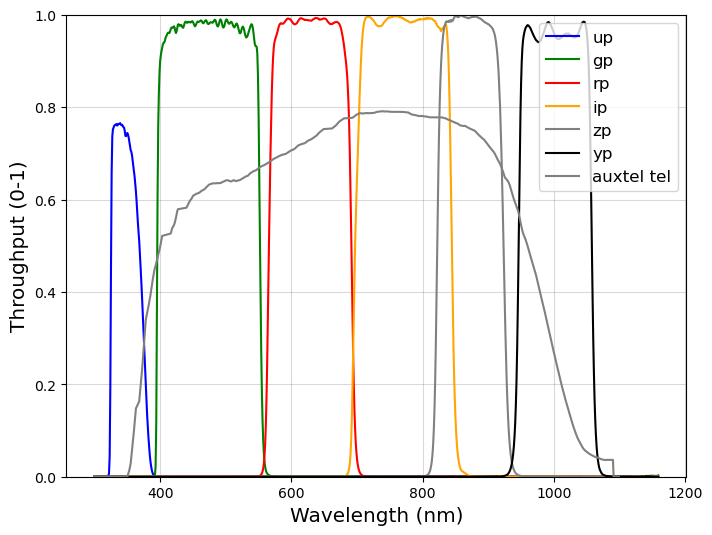

In [9]:
# Plot the curves .. see what we have. 
filtercolors = {'up':'b', 'gp':'g', 'rp':'r', 'ip':'orange', 'zp':'grey', 'yp':'k'}

plt.figure(figsize=(8,6))
for f in filterlist:
    plt.plot(sdss_p[f].wavelen, sdss_p[f].sb, color=filtercolors[f], label=f)
    
plt.plot(tel_auxtel.wavelen, tel_auxtel.sb, color="grey", label="auxtel tel")

plt.xlabel("Wavelength (nm)", fontsize='x-large')
plt.ylabel("Throughput (0-1)", fontsize='x-large')
plt.ylim(0, 1)
plt.grid(True, alpha=0.3, color='gray')
plt.legend(loc='upper right', fancybox=True, fontsize='large')

In [10]:
tr_u = np.interp(sdss_p["up"].wavelen, tel_auxtel.wavelen, tel_auxtel.sb)
tr_g = np.interp(sdss_p["gp"].wavelen, tel_auxtel.wavelen, tel_auxtel.sb)
tr_r = np.interp(sdss_p["rp"].wavelen, tel_auxtel.wavelen, tel_auxtel.sb)
tr_i = np.interp(sdss_p["ip"].wavelen, tel_auxtel.wavelen, tel_auxtel.sb)
tr_z = np.interp(sdss_p["zp"].wavelen, tel_auxtel.wavelen, tel_auxtel.sb)
tr_y = np.interp(sdss_p["yp"].wavelen, tel_auxtel.wavelen, tel_auxtel.sb)

In [12]:
auxtel = {}
auxtel["up"] = Bandpass(wavelen=sdss_p["up"].wavelen,sb=tr_u * sdss_p["up"].sb)
auxtel["gp"] = Bandpass(wavelen=sdss_p["gp"].wavelen,sb=tr_g * sdss_p["gp"].sb)
auxtel["rp"] = Bandpass(wavelen=sdss_p["rp"].wavelen,sb=tr_r * sdss_p["rp"].sb)  
auxtel["ip"] = Bandpass(wavelen=sdss_p["ip"].wavelen,sb=tr_i * sdss_p["ip"].sb)  
auxtel["zp"] = Bandpass(wavelen=sdss_p["zp"].wavelen,sb=tr_z * sdss_p["zp"].sb) 
auxtel["yp"] = Bandpass(wavelen=sdss_p["yp"].wavelen,sb=tr_z * sdss_p["yp"].sb) 

Text(0.5, 1.0, 'Auxtel Photometry')

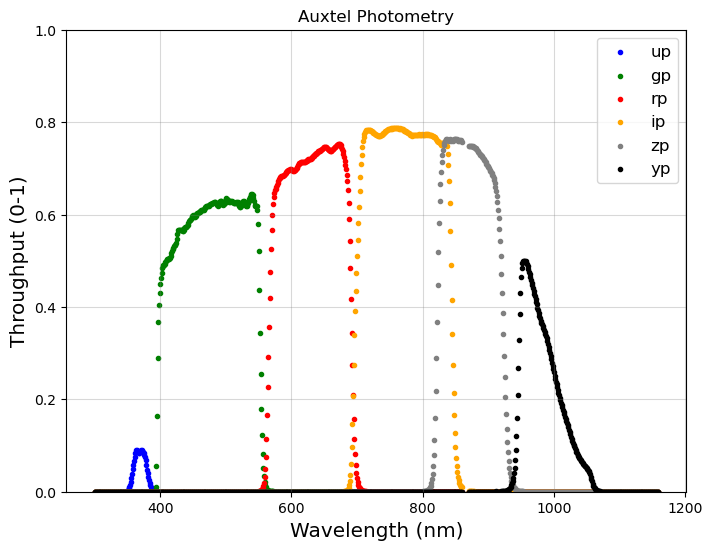

In [13]:
plt.figure(figsize=(8,6))
for f in filterlist:
    plt.scatter(auxtel[f].wavelen, auxtel[f].sb, color=filtercolors[f],marker='.' ,label=f)
    
plt.xlabel("Wavelength (nm)", fontsize='x-large')
plt.ylabel("Throughput (0-1)", fontsize='x-large')
plt.ylim(0, 1)
plt.grid(True, alpha=0.3, color='gray')
plt.legend(loc='upper right', fancybox=True, fontsize='large')
plt.title("Auxtel Photometry")

## Find boundaries and borders of filters

Text(0, 0.5, 'number of bins')

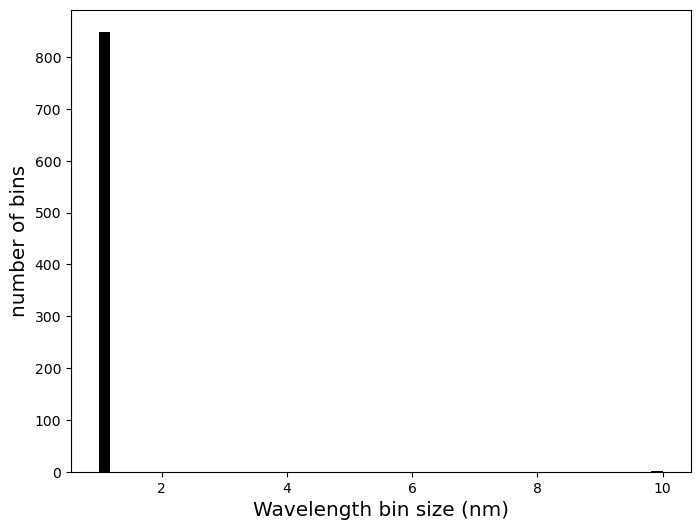

In [14]:
plt.figure(figsize=(8,6))
for f in filterlist:
    plt.hist(np.diff(auxtel[f].wavelen),bins=50, facecolor=filtercolors[f], label=f)

plt.xlabel("Wavelength bin size (nm)", fontsize='x-large')
plt.ylabel("number of bins", fontsize='x-large')

In [15]:
FILTERS = np.zeros((len(filterlist),4))

transm_thr = 0.01
for idx,f in enumerate(filterlist):
    indexes = np.where(auxtel[f].sb>transm_thr)[0]
    wls = auxtel[f].wavelen[indexes]
    WLMIN = wls.min()
    WLMAX = wls.max()
    WLMEAN = wls.mean()
    WLWIDTH = WLMAX - WLMIN
    FILTERS[idx,0] = WLMIN
    FILTERS[idx,1] = WLMAX
    FILTERS[idx,2] = WLMEAN
    FILTERS[idx,3] = WLWIDTH
    print(f,wls.min(),wls.max(),np.mean(np.diff(wls)))

up 353.0 385.0 1.0
gp 393.0 560.0 1.0
rp 557.0 703.0 1.0
ip 688.0 859.0 1.0
zp 812.0 938.0 1.0769230769230769
yp 934.0 1060.0 1.0


In [16]:
FILTERS

array([[ 353.        ,  385.        ,  369.        ,   32.        ],
       [ 393.        ,  560.        ,  476.5       ,  167.        ],
       [ 557.        ,  703.        ,  630.        ,  146.        ],
       [ 688.        ,  859.        ,  773.5       ,  171.        ],
       [ 812.        ,  938.        ,  875.76271186,  126.        ],
       [ 934.        , 1060.        ,  997.        ,  126.        ]])

Text(0.5, 1.0, 'Auxtel Photometry')

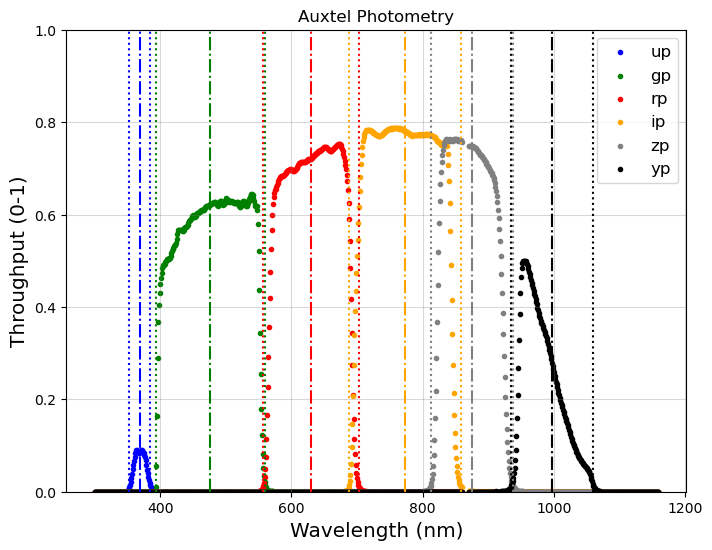

In [17]:
plt.figure(figsize=(8,6))
for idx,f in enumerate(filterlist):
    plt.scatter(auxtel[f].wavelen, auxtel[f].sb, color=filtercolors[f],marker='.' ,label=f)
    plt.axvline(FILTERS[idx,0],color=filtercolors[f],linestyle=":")
    plt.axvline(FILTERS[idx,1],color=filtercolors[f],linestyle=":")
    plt.axvline(FILTERS[idx,2],color=filtercolors[f],linestyle="-.")
plt.xlabel("Wavelength (nm)", fontsize='x-large')
plt.ylabel("Throughput (0-1)", fontsize='x-large')
plt.ylim(0, 1)
plt.grid(True, alpha=0.3, color='gray')
plt.legend(loc='upper right', fancybox=True, fontsize='large')
plt.title("Auxtel Photometry")

# Need to resample

- rubinsim assure really regular grid for wavelengths otherwise it generate an error in sed.py
- thus the transmission curve is resampled using a wavelength grid of 0.1 nm

In [18]:
STEP_WL = 0.1

In [19]:
auxtel_sdss = {}
for idx,f in enumerate(filterlist):
    WL = np.arange(FILTERS[idx,0],FILTERS[idx,1],STEP_WL)
    tr = np.interp(WL, auxtel[f].wavelen, auxtel[f].sb)
    auxtel_sdss[f] =  Bandpass(wavelen=WL,sb=tr)

Text(0.5, 1.0, 'Auxtel Photometry resampled')

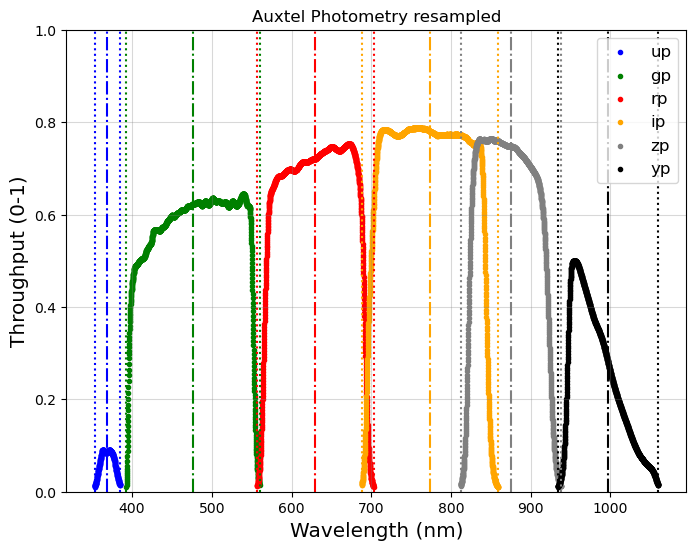

In [20]:
plt.figure(figsize=(8,6))
for idx,f in enumerate(filterlist):
    plt.scatter(auxtel_sdss[f].wavelen, auxtel_sdss[f].sb, color=filtercolors[f],marker='.' ,label=f)
    plt.axvline(FILTERS[idx,0],color=filtercolors[f],linestyle=":")
    plt.axvline(FILTERS[idx,1],color=filtercolors[f],linestyle=":")
    plt.axvline(FILTERS[idx,2],color=filtercolors[f],linestyle="-.")
plt.xlabel("Wavelength (nm)", fontsize='x-large')
plt.ylabel("Throughput (0-1)", fontsize='x-large')
plt.ylim(0, 1)
plt.grid(True, alpha=0.3, color='gray')
plt.legend(loc='upper right', fancybox=True, fontsize='large')
plt.title("Auxtel Photometry resampled")

### Need to extend to zero before and after


In [23]:
WLMIN = 300.
WLMAX = 1200.
WL = np.arange(WLMIN,WLMAX,STEP_WL) 

In [24]:
auxtel_sdss_ext = {}
for idx,f in enumerate(filterlist):
    func_transmission = interp1d(auxtel_sdss[f].wavelen, auxtel_sdss[f].sb, bounds_error=False, fill_value=0)
    tr = func_transmission(WL)
    auxtel_sdss_ext[f] =  Bandpass(wavelen=WL,sb=tr)

Text(0.5, 1.0, 'Auxtel Photometry resampled and extended')

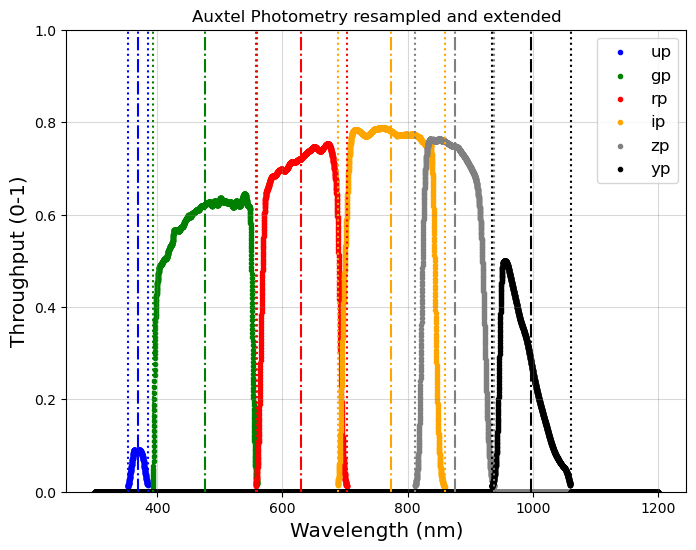

In [25]:
plt.figure(figsize=(8,6))
for idx,f in enumerate(filterlist):
    plt.scatter(auxtel_sdss_ext[f].wavelen, auxtel_sdss_ext[f].sb, color=filtercolors[f],marker='.' ,label=f)
    plt.axvline(FILTERS[idx,0],color=filtercolors[f],linestyle=":")
    plt.axvline(FILTERS[idx,1],color=filtercolors[f],linestyle=":")
    plt.axvline(FILTERS[idx,2],color=filtercolors[f],linestyle="-.")
plt.xlabel("Wavelength (nm)", fontsize='x-large')
plt.ylabel("Throughput (0-1)", fontsize='x-large')
plt.ylim(0, 1)
plt.grid(True, alpha=0.3, color='gray')
plt.legend(loc='upper right', fancybox=True, fontsize='large')
plt.title("Auxtel Photometry resampled and extended")

# Save File

In [26]:
for f in filterlist:
    filename = f"auxtel_sdss_{f}_total.dat"
    fullfilename = os.path.join(fdir,filename)
    auxtel_sdss_ext[f].write_throughput(fullfilename)